In [5]:
# For data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import missingno as msno
import miceforest as mf

# For data cleaning and procesing
import string
import nltk

nltk.download("stopwords")
nltk.download("wordnet")
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

# For machnie learning model training
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, cross_val_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    make_scorer,
)
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.feature_selection import RFE
import shap
import warnings
import joblib
from sklearn.metrics import f1_score, classification_report
warnings.simplefilter(action="ignore", category=FutureWarning)

print("Everything imported successfully✅")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pheonix/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/pheonix/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Everything imported successfully✅


/home/pheonix/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Reading the data from csv file
df = pd.read_csv("../Dataset/Fake_job_data.csv")

In [9]:
# Checking the shape of dataset
print("Shape of dataframe :", df.shape)

Shape of dataframe : (17880, 18)


In [10]:
# CHecking any some random rows from the dataset
df.sample(3)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
11902,11903,Cad Designer,"US, PA, Philadelphia",NaN,NaN,We Provide Full Time Permanent Positions for m...,(We have more than 1500+ Job openings in our w...,NaN,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
5730,5731,Web Developer,"SE, AB, Stockholm",Technology,NaN,We started making apps the day App Store opene...,Sweden’s No 1 is looking for talented people t...,Qualifications- Minimum 2 years of full...,"What we offer- A dynamic, talented and h...",0,1,0,Full-time,Mid-Senior level,NaN,Internet,Information Technology,0
8810,8811,Mechanical Designer,"US, WI, Waukesha",NaN,NaN,How often do you see the combination of solid ...,"Are you a detail oriented, self motivated, pro...",Two to five years of direct experience in desi...,Hydro-Thermal Corporation is an equal opportun...,0,1,1,Full-time,NaN,NaN,NaN,NaN,0


In [11]:
# Dropping unnecessary column from dataframe
df.drop(["job_id"], axis=1, inplace=True)

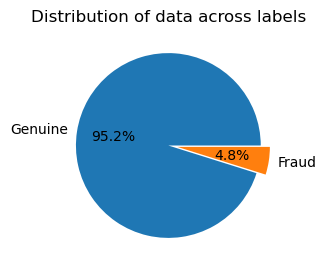

In [12]:
# Let's check the distribution of data across labels 0 -> Genuine and 1 -> Fraud
fig, ax = plt.subplots(figsize=(3, 3))

ex = [0.0, 0.1]
plt.pie(
    df["fraudulent"].value_counts(),
    labels=["Genuine", "Fraud"],
    autopct="%1.1f%%",
    explode=ex,
)
plt.title("Distribution of data across labels")
plt.show()

In [14]:
fake_jobs = df[df['fraudulent'] == 1]
genuine_jobs = df[df['fraudulent'] == 0].sample(fake_jobs.shape[0])

fake_jobs.reset_index(drop=True,inplace=True)
genuine_jobs.reset_index(drop=True,inplace=True)

In [15]:
# Combining the dataframes
df = pd.concat([fake_jobs,genuine_jobs],axis=0)

# Shuffling the data
df = df.sample(frac=1).reset_index(drop=True)

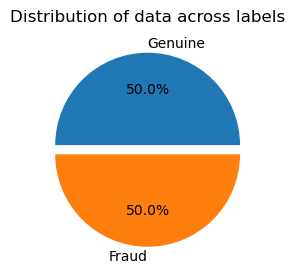

In [16]:
# Let's check the distribution of data across labels 0 -> Genuine and 1 -> Fraud
fig, ax = plt.subplots(figsize=(3, 3))

ex = [0.0, 0.1]
plt.pie(
    df["fraudulent"].value_counts(),
    labels=["Genuine", "Fraud"],
    autopct="%1.1f%%",
    explode=ex,
)
plt.title("Distribution of data across labels")
plt.show()

In [17]:
# Let's get some basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732 entries, 0 to 1731
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                1732 non-null   object
 1   location             1696 non-null   object
 2   department           652 non-null    object
 3   salary_range         381 non-null    object
 4   company_profile      1002 non-null   object
 5   description          1731 non-null   object
 6   requirements         1444 non-null   object
 7   benefits             1000 non-null   object
 8   telecommuting        1732 non-null   int64 
 9   has_company_logo     1732 non-null   int64 
 10  has_questions        1732 non-null   int64 
 11  employment_type      1312 non-null   object
 12  required_experience  951 non-null    object
 13  required_education   870 non-null    object
 14  industry             1199 non-null   object
 15  function             1069 non-null   object
 16  fraudu

In [18]:
# Changing the datatype to reduce the memory usage
int_cols = df.select_dtypes(include=np.int64)
float_cols = df.select_dtypes(include=np.float64)

df[int_cols.columns] = df[int_cols.columns].astype(np.int32)
df[float_cols.columns] = df[float_cols.columns].astype(np.float32)

In [19]:
# Let's check if there are any duplicate values
duplicate_values = df.duplicated().sum()
if duplicate_values != 0:
    print("Total duplicate values : " + str(duplicate_values))
    df.drop_duplicates(inplace=True)
    print("Duplicate values removed")

Total duplicate values : 10
Duplicate values removed


In [20]:
# Let's check if there are any missing values
df.isnull().mean() * 100

title                   0.000000
location                2.090592
department             62.311266
salary_range           77.990708
company_profile        41.986063
description             0.058072
requirements           16.550523
benefits               42.218351
telecommuting           0.000000
has_company_logo        0.000000
has_questions           0.000000
employment_type        24.099884
required_experience    44.889663
required_education     49.651568
industry               30.662021
function               38.095238
fraudulent              0.000000
dtype: float64

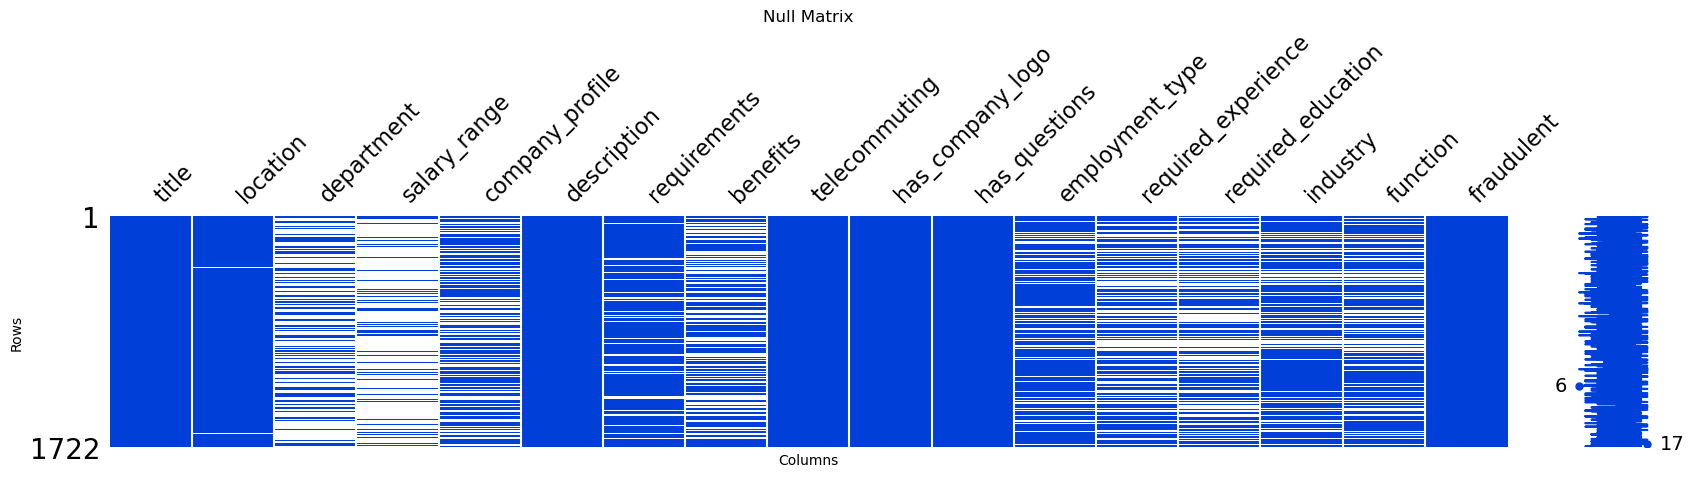

In [21]:
# Plot the null matrix to visualize if there are null values left
msno.matrix(df, figsize=(20, 3), color=(0, 0.25, 0.85))

# Set plot labels and title
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.title("Null Matrix")

# Show the plot
plt.show()

In [22]:
print(
    "Fraud JD having no department mentioned : "
    + str(df[df["fraudulent"] == 1]["department"].isnull().sum())
)

Fraud JD having no department mentioned : 524


In [23]:
# Let's create a copy of the dataframe and on that copy we will explore various processing techniques
temp_df = df.copy()

In [24]:
salary_range_present = []

for i in range(len(temp_df["salary_range"])):
    if pd.isna(temp_df["salary_range"].iloc[i]):
        salary_range_present.append(0)  # Salary range not provided
    else:
        salary_range_present.append(1)  # Salary range provided

temp_df["Salary_range_provided"] = salary_range_present
temp_df.drop(["salary_range"], inplace=True, axis=1)